Folder path containing data: C:\Users\ytsma22c\Documents\GitHub\auto-modelling\test_data
Spectra filename: spectra_multi
Metadata filename: meta_multi_stratified
File path to export results: C:\Users\ytsma22c\Documents\GitHub\auto-modelling\test_results
Maximum number of PLS components (default=30): 

Loading data
Identified variables to be predicted by the model: SiO2, TiO2, Al2O3

Cross-validating


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [03:59<00:00,  8.25s/it]


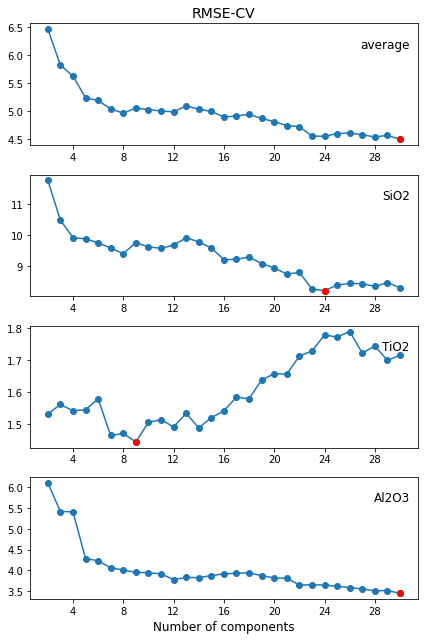

Which component model should be used for training? (refer to figure, default = best average): 8


In [161]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import warnings
import os
import pickle
from statistics import mean
from tqdm import tqdm
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from sklearn.cross_decomposition import PLSRegression
from model_tools import check_csv, make_bool, select_spectra

'''
by Cai Ytsma (cai@caiconsulting.co.uk)
Last updated 15 September 2022

Script to make PLS2 models, where one model predicts multiple y variables. 
If only modelling for one variable, PLS1 regression is included in spectral_regression_modelling.py
'''

#-------------------#
# INPUT INFORMATION #
#-------------------#
# data folder
data_folder = input('Folder path containing data: ')
while not os.path.exists(data_folder):
    print(f'Error: path {data_folder} does not exist\n')
    data_folder = input('Folder path containing data: ')
    
all_files = os.listdir(data_folder)

# spectra
spectra_file = check_csv(input('Spectra filename: '))
while spectra_file not in all_files:
    print(f'Error: file {spectra_file} not in data folder\n')
    spectra_file = check_csv(input('Spectra filename: '))
spectra_path = os.path.join(data_folder, spectra_file)

# metadata
meta_file = check_csv(input('Metadata filename: '))
while meta_file not in all_files:
    print(f'Error: file {meta_file} not in data folder\n')
    meta_file = check_csv(input('Metadata filename: '))
meta_path = os.path.join(data_folder, meta_file)

# folder to export results to
outpath = input('File path to export results: ')
while not os.path.exists(outpath):
    print(f'Error: path {outpath} does not exist\n')
    outpath = input('File path to export results: ')
    
# define maximum number of components
default_max_components = 30
max_components = int(input('Maximum number of PLS components (default=30): ') or default_max_components)

#----------------#
# PREP PROCEDURE #
#----------------#
# read in data
print('\nLoading data')
spectra = pd.read_csv(spectra_path)
axis = list(spectra['wave'].values)
meta = pd.read_csv(meta_path)

# check has folds column
fold_col = 'Folds'
if fold_col not in meta.columns:
    raise ValueError(f"Metadata must have a universal '{fold_col}' column assigned to split the data for cross-validation")

# check data in same order
check = list(spectra.columns[1:]) == list(meta['pkey'].values)
if not check:
    raise ValueError('Spectra and metadata samples need to be in same order')

# extract variables to be run
var_to_run = [col for col in meta.columns if (col not in ['pkey', 'Sample Name', 'Sample_Name']) and ('Folds' not in col)]
if len(var_to_run) == 1:
    raise ValueError(f'Only one variable, {var_to_run[0]}, is in the metadata. PLS2 requires multiple y variables.')
all_var = ', '.join(var_to_run)
print('Identified variables to be predicted by the model:', all_var)

# remove samples without compositions for all variables
if meta.isnull().values.any():
    print('Warning: Samples without compositions for all variables will be dropped')
    meta = meta.dropna()

# get spectra for those samples
cols = list(meta.pkey)
cols.insert(0,'wave')
spectra = spectra[cols]

#--------------------#
# FORMAT DATA FOR CV #
#--------------------#
# find minimum number of samples in the folds, in cas max_components greater
n_samples_list = []

## remove test data if using it
#if test_fold:
#    temp_meta = self.meta[self.meta[fold_col] != test_fold].copy()
#else:
#    temp_meta = self.meta.copy()

all_folds = list(meta[fold_col].unique())
if -1 in all_folds:
    all_folds.remove(-1)

data_dict = {}
for fold in all_folds:

    # training data
    train_meta = meta[(meta[fold_col] != fold) &
                      (meta[fold_col] != -1)].reset_index(drop=True)
    X_train = select_spectra(spectra, train_meta.pkey)
    y_train = train_meta[var_to_run].values
    n_samples_list.append(len(y_train))

    # held-out data
    test_meta = meta[meta[fold_col] == fold].reset_index(drop=True)
    X_test = select_spectra(spectra, test_meta.pkey)
    y_test = test_meta[var_to_run].values
    n_samples_list.append(len(y_test))

    # add datasets to dictionary
    data_dict[fold] = {'train_spectra':X_train,
                       'train_metadata':y_train,
                       'test_spectra':X_test,
                       'test_metadata':y_test}

min_samples = min(n_samples_list)
if min_samples < max_components:
    print(f'Maximum number of components, {max_components}, is larger than minimum number of samples in the folds, {min_samples}. Setting {min_samples} as max components')
    max_components = min_samples
        
#--------#
# RUN CV #
#--------#
print('\nCross-validating')
# initialize CV results summary
overall_cv_results = {'average':[]}
for var in var_to_run:
    overall_cv_results[var] = []
var_names = list(overall_cv_results.keys())
n_var = len(var_names)
    
def run_CV_PLS2(model):
    
    '''
    Function to return each variable's RMSE-CV
    per model, as well as the average RMSE-CV
    '''

    # initialize CV results summary
    cv_results = {'average':[]}
    for var in var_to_run:
        cv_results[var] = []
        
    for fold in list(data_dict.keys()):

        # get data
        X_train = data_dict[fold]['train_spectra']
        X_test = data_dict[fold]['test_spectra']
        y_train = data_dict[fold]['train_metadata']
        y_test = data_dict[fold]['test_metadata']

        # run model
        model.fit(X_train, y_train)
        # predictions
        preds = model.predict(X_test)
        pred_df = pd.DataFrame(preds)
        pred_df.columns = [f'pred_{var}' for var in var_to_run]
        # actual values
        actual_df = pd.DataFrame(y_test)
        actual_df.columns = [f'actual_{var}' for var in var_to_run]
        # combine
        pred_true = pred_df.merge(actual_df, left_index=True, right_index=True)
        
        # get individual RMSE-Ps
        indiv_rmseps = []
        for var in var_to_run:
            rmsep = sqrt(mean_squared_error(pred_true[f'actual_{var}'], pred_true[f'pred_{var}']))
            cv_results[var].append(rmsep) # value for this fold
            indiv_rmseps.append(rmsep) # to get average for fold
            
        # calculate overall average for this fold
        avg_rmsep = mean(indiv_rmseps)
        cv_results['average'].append(avg_rmsep)
        
    #then, append means to overall dict
    for var in var_to_run+['average']:
        overall_cv_results[var].append(mean(cv_results[var]))
        
component_range = np.arange(start=2, stop=max_components+1, step=1)
for n_components in tqdm(component_range):
    # define model
    run_CV_PLS2(PLSRegression(n_components = n_components, scale=False))
    
# cumulate best results per variable
best_results = dict()
for var in var_names:
    results = dict(zip(overall_cv_results[var], component_range))
    min_rmsecv = min(overall_cv_results[var])
    best_component = results[min_rmsecv]
    best_results[var] = [best_component, min_rmsecv]

#--------------------#
# DISPLAY CV RESULTS #
#--------------------#
fig, axes = plt.subplots(nrows=n_var,
                         figsize=(6,9))
for i in np.arange(n_var):
    
    # get variable name and best results
    var = var_names[i]
    best_component = best_results[var][0]
    best_rmsecv = best_results[var][1]
    
    # PLOT
    # dots
    axes[i].scatter(component_range, overall_cv_results[var])
    # line
    axes[i].plot(component_range, overall_cv_results[var])
    # best point
    axes[i].plot(best_component, best_rmsecv, color='red', marker='o')
    # label
    axes[i].annotate(var, xy=(0.98, 0.8), ha='right', xycoords='axes fraction', fontsize=12)
    axes[i].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

axes[0].set_title('RMSE-CV', fontsize=14)
axes[n_var-1].set_xlabel('Number of components', fontsize=12)  
plt.savefig(f'{outpath}\\RMSECV_result_comparison.jpg', dpi=600)
plt.savefig(f'{outpath}\\RMSECV_result_comparison.eps', dpi=600)
plt.tight_layout()
# show plot
plt.show(block=False)

# choose model to train on
component_to_use = int(input('Which component model should be used for training? (refer to figure, default = best average): ') or best_results['average'][0])

# close figure
plt.close()

#-------------#
# TRAIN MODEL #
#-------------#
# format training data
train_meta = meta[(meta[fold_col] != -1) &
                  (~meta[fold_col].isnull())]
y_train = train_meta[var_to_run].values
train_names = train_meta['pkey'].values
X_train = select_spectra(spectra, train_names)
# make model
model = PLSRegression(n_components = component_to_use, scale=False)
model.fit(X_train, y_train)
# export
pickle.dump(model, open(f"{outpath}\\PLS2_model_{all_var.replace(', ','_')}.asc", 'wb'), protocol=0)

In [194]:
train_rmsecv_list = []
train_rmsec_list = []
train_r2_list = []
train_adj_r2_list = []

for var in var_to_run:
    
    # -2 to offset bc starts at 2
    rmsecv = overall_cv_results[var][component_to_use-2]
    
    actual = train_pred_true[f'{var}_actual']
    pred = train_pred_true[f'{var}_pred']
    
    rmsec = sqrt(mean_squared_error(actual, pred))
    r2 = r2_score(actual, pred)
    adj_r2 = 1 - (1-r2)*(len(train_pred_true) - 1) / (len(train_pred_true) - (train_pred_true.shape[1] - 1) - 1)
    
    train_rmsecv_list.append(rmsecv)
    train_rmsec_list.append(rmsec)
    train_r2_list.append(r2)
    train_adj_r2_list.append(adj_r2)

C:\Users\ytsma22c\AppData\Local\Continuum\xraylarch\envs\auto\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


In [218]:
# overall model info
model_info = f'''*PLS2 Model Information*

Predicted variables:,{all_var.replace(',', '')}
Number of standards:,{len(y_train)}
Number of model components:,{component_to_use}
Average RMSE-CV:,{round(mean(train_rmsecv_list),3)}
Average RMSE-C:,{round(mean(train_rmsec_list),3)}
Average R2:,{round(mean(train_r2_list),3)}
Average adjusted R2:,{round(mean(train_adj_r2_list),3)}

'''

In [205]:
variable_info = pd.DataFrame({
    'Variable' : var_to_run,
    'Model intercept' : list(model.intercept_),
    'RMSE-CV' : train_rmsecv_list,
    'RMSE-C' : train_rmsec_list,
    'R2' : train_r2_list,
    'Adjusted R2' : train_adj_r2_list
})

with open(f'PLS2_model_info_{all_var.replace(', ','_')}.csv', 'a', newline='\n') as file:
    file.write(model_info)
    variable_info.to_csv(file, index=False)